# Preparation

In [1]:
# These are my default settings
import warnings
warnings.filterwarnings("ignore")

import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import joblib

plt.rcParams["figure.figsize"] = (12, 6)
sns.set()
pd.set_option("display.max_columns", None)


### Load IMDB dataset

In [2]:
from tensorflow.keras.datasets import imdb

(train_samples, train_labels), (test_samples, test_labels) = imdb.load_data(num_words=10000)

In [3]:
print(train_samples, train_labels)

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

In [4]:
print("list1:",len(train_samples[0]),"\nlist2:",len(train_samples[1]))

list1: 218 
list2: 189


Each list has different longer of words

### Encode the integer seq

In [53]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_samples).astype('int8')
x_test = vectorize_sequences(test_samples).astype('int8')

In [50]:
# Vectorize labels
y_train = np.asarray(train_labels).astype('int8')
y_test = np.asarray(test_labels).astype('int8')

In [54]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train)

(25000, 10000) (25000,) (25000, 10000) (25000,)
[[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]]


In [52]:
print(y_test)

[0 1 1 ... 0 0 0]


# Model training

#### In this project, I use sklearn clf model. In this case, I choose simple LogisticRegression model with BayesSearchCV.

In [55]:
# model parametres
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from skopt import BayesSearchCV


params = {
    "C" :  [0.05,0.06,0.07,0.08,0.09,0.1,
            # 0.11,0.12,0.13,0.14,0.15
            ],
    # "max_iter": list(range(35, 46, 1))
}

In [56]:
bscv = BayesSearchCV(
    estimator=LogisticRegression(),
    search_spaces=params,
    n_jobs=1,
    cv=5,
    n_iter=10,
    scoring=make_scorer(log_loss, greater_is_better=False)
    
)

In [57]:

bscv.fit(x_train.reshape(len(x_train), -1), y_train)


BayesSearchCV(cv=5, estimator=LogisticRegression(), n_iter=10,
              scoring=make_scorer(log_loss, greater_is_better=False),
              search_spaces={'C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]})

In [58]:
bscv.best_params_

OrderedDict([('C', 0.1)])

#### To evaluate, I choose accuracy metrics.
$$
Accuracy= 
\frac{Number of Correct Predictions}{Total Number of Predictions}
$$

In [59]:
b_estimator = bscv.best_estimator_

In [60]:
# evaluation
y_pred = b_estimator.predict(x_test.reshape(len(x_test), -1))


correct_predictions = 0

for predicted, true in zip(y_pred, y_test):
    if predicted == true:
        correct_predictions += 1

total_samples = len(y_pred)
accuracy = correct_predictions / total_samples

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8810


### Evaluate with matrix

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def make_report(model, X, y, label_0, label_1):
    """This function lets Classification_report, Confusion Matrix(Heat map) and ROC-AUC out. FOR BINARY CLASSIFICATION ONLY"""
    
    # Classification_report
    y_pred = model.predict(X)
    cr = classification_report(y_true=y, y_pred=y_pred>0.75)
    print(cr)
    
    # Confusion Matrix(Heat map)
    cm = confusion_matrix(y_true=y, y_pred=y_pred>0.75)
    cm_heat = pd.DataFrame(data=cm, index=[label_0, label_1], 
                           columns=[label_0, label_1])
    sns.heatmap(cm_heat, square=True, annot=True, cmap="Spectral")
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.yticks(rotation=0)
    plt.show()
    

    # ROC-AUC

    fpr, tpr, thresholds = roc_curve(y, y_pred)
    ac = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%ac)
    plt.fill_between(fpr, tpr, 0, color="red", alpha=0.1)
    plt.legend()
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    # plt.grid()
    plt.show()

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



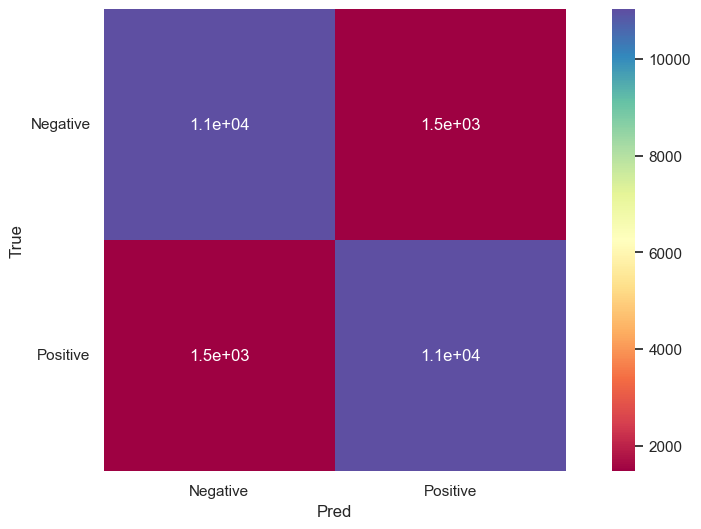

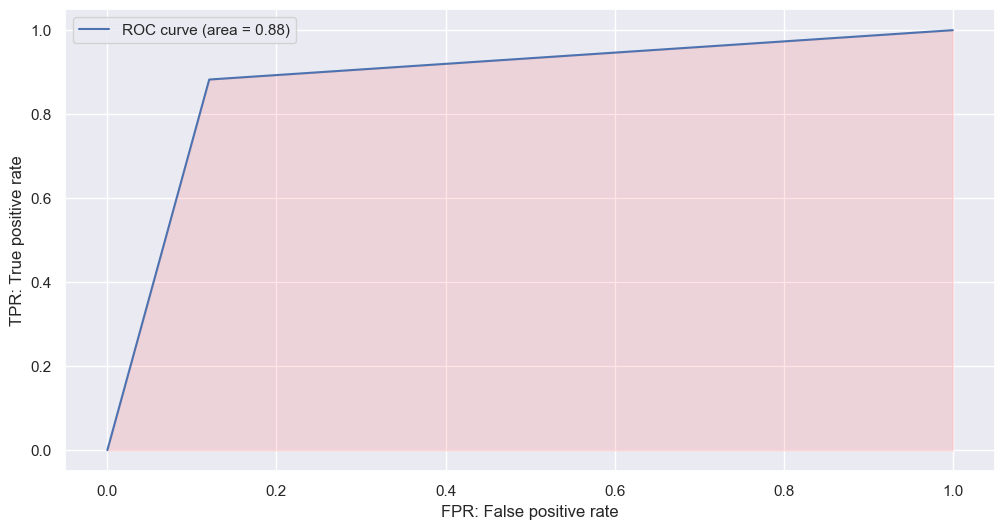

In [61]:
make_report(b_estimator, x_test.reshape(len(x_test), -1), y_test, "Negative", "Positive")